<a href="https://colab.research.google.com/github/carloalbertobono/Crowd4SDG-VisualCit-Interface/blob/main/pipeline_validation_environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
     |████████████████████████████████| 24.8 MB 5.9 MB/s 


In [ ]:
import glob, os
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
import plotly.express as px
from sklearn.metrics import precision_recall_fscore_support

from google.colab import drive
drive.mount('/content/gdrive')

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# pd.reset_option('^display.', silent=True)

# 'annotations' è il nome di un link a un percorso "Shared with me" di Google Drive
basepath = '/content/gdrive/MyDrive/annotations'

def increase_font():
  from IPython.display import Javascript
  display(Javascript('''
  for (rule of document.styleSheets[0].cssRules){
    if (rule.selectorText=='body') {
      rule.style.fontSize = '18px'
      break
    }
  }
  '''))

# Map between dataset and filter configuration
mapping = {"PublicPlace": {
                            "name": "SceneClassifier",
                            "object": "outdoor",
                            "confidence": 0.01,
                            "index": 0
                        },
           "Photo": {
                            "name": "MemeClassifier",
                            "confidence": 0.01,
                            "index": 0
                        },
           "TwoPersons": {
                            "name": "YOLOv5ObjectDetector",
                            "confidence": 0.01,
                            "min_items": 2,
                            "index": 0
                        }
           }

Mounted at /content/gdrive


In [ ]:
input_data_path = os.path.join(basepath, 'input/crawl-dedup-2020082017-w34-project162-1Ktweets-benchmark-meme-nsfw-public_private-yolo.csv')
questions = pd.read_csv(input_data_path)
quest = questions[['id', 'media_url']] # only data
quest.to_csv(os.path.join(basepath, 'output/input_data.csv'), index=False)
questions

,id,media_url,meme,nsfw,public_private,yolo,accepted
0,1296476570702487554,http://pbs.twimg.com/media/Ef4ChezX0AAtO9P.png,245.35596,251.24902,313.21777,927.05078,yes
1,1296476565535182848,http://pbs.twimg.com/media/Ef4CkMJX0AA1Hhs.jpg,99.75513,0.00000,0.00000,0.00000,no
2,1296476565249949696,http://pbs.twimg.com/media/Ef4CkBBXoAMne8W.jpg,98.87012,0.00000,0.00000,0.00000,no
3,1296476564998295554,http://pbs.twimg.com/media/Ef4CkNQXgAAPJUL.jpg,174.25195,225.93091,253.14087,657.36401,yes
4,1296476560074182656,http://pbs.twimg.com/media/Ef4Ci_zUMAQOFk2.jpg,130.25317,342.84302,558.58374,749.32373,no
...,...,...,...,...,...,...,...
913,1296474493116977153,http://pbs.twimg.com/tweet_video_thumb/Ef4ArAi...,115.70996,211.11792,211.15674,624.53931,no
914,1296474492433309701,http://pbs.twimg.com/media/Ef4Aq3dXgAMD4-n.jpg,98.64990,0.00000,0.00000,0.00000,no
915,1296474492378779650,http://pbs.twimg.com/media/Ef4AlnWUYAAV5Fc.jpg,101.82495,205.98413,226.63208,614.92993,yes
916,1296474489010769921,http://pbs.twimg.com/media/Ef4ArW4XoAEe8A3.jpg,90.80518,203.60596,209.61011,614.19019,yes


In [ ]:
df = None

def load_df(subfolder):

  print("> Folder:", subfolder)

  question_folder = os.path.join(basepath, subfolder)
  os.chdir(question_folder)

  df = None

  for file in glob.glob("*.csv"):

      if 'merged' in file: continue
      print(file)
      
      # Load new table
      df_ = pd.read_csv(os.path.join(question_folder, file))

      # Remove invalid answers
      df_ = df_[df_['Option Chosen'].isin(['Yes', 'No'])]

      # Replace answers with integer
      df_.iloc[:,-1] = df_.iloc[:,-1].map({'No':0, 'Yes':1})

      # Check if first
      if df is None:
        df = df_
        print(len(df))
      else:
        df = df.merge(df_, on=['Tweet ID', 'Media URL'])
        print(len(df))

  # Rename columns
  df.columns = df.columns[:2].tolist() + ['Option Chosen ' + str(i) for i in range(len(df.columns)-2)]

  # Measure agreement
  contributors = df.shape[1]-2
  df['SumYes'] = df.iloc[:,2:].sum(axis=1)
  df['Agreement'] = df['SumYes'] / contributors
  df['Contributors'] = contributors

  return df

# Load all subfolder data

subfolders = ['TwoPersons', 'Photo', 'PublicPlace']
dfs = {s: load_df(s) for s in subfolders}

> Folder: TwoPersons
TwoPersons - cb - crawl-dedup-2020082017-w34-project162-1Ktweets-benchmark-meme-nsfw-public_private-yolo.csv
915
TwoPersons - bp - crawl-dedup-2020082017-w34-project162-1Ktweets-benchmark-meme-nsfw-public_private-yolo.csv
504
TwoPersons - er - crawl-dedup-2020082017-w34-project162-1Ktweets-benchmark-meme-nsfw-public_private-yolo.csv
504
TwoPersons - mv - crawl-dedup-2020082017-w34-project162-1Ktweets-benchmark-meme-nsfw-public_private-yolo.csv


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Option Chosen_x'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


501
> Folder: Photo
Photo - bp - crawl-dedup-2020082017-w34-project162-1Ktweets-benchmark-yolo-public_private-nsfw-meme.csv
914
Photo - cb - crawl-dedup-2020082017-w34-project162-1Ktweets-benchmark-meme-nsfw-public_private-yolo.csv
913
Photo - er - crawl-dedup-2020082017-w34-project162-1Ktweets-benchmark-meme-nsfw-public_private-yolo.csv
895
Photo -  cc - crawl-dedup-2020082017-w34-project162-1Ktweets-benchmark-meme-nsfw-public_private-yolo.csv
894
Photo - mv - crawl-dedup-2020082017-w34-project162-1Ktweets-benchmark-meme-nsfw-public_private-yolo.csv
890
> Folder: PublicPlace
Public - mv- crawl-dedup-2020082017-w34-project162-1Ktweets-benchmark-meme-nsfw-public_private-yolo.csv
915
Public - cb - crawl-dedup-2020082017-w34-project162-1Ktweets-benchmark-meme-nsfw-public_private-yolo.csv
914
Public - bp - crawl-dedup-2020082017-w34-project162-1Ktweets-benchmark-meme-nsfw-public_private-yolo.csv
894
Public - er - crawl-dedup-2020082017-w34-project162-1Ktweets-benchmark-meme-nsfw-public_pri

In [ ]:
#@title
import ipywidgets as widgets

selection = widgets.Dropdown(
    options=subfolders,
    value=subfolders[0],
    description='Question:',
    disabled=False,
)
selection

Dropdown(description='Question:', options=('TwoPersons', 'Photo', 'PublicPlace'), value='TwoPersons')

In [ ]:
folder = selection.value
df = dfs[folder]
df_orig = df.copy()
df

,Tweet ID,Media URL,Option Chosen 0,Option Chosen 1,Option Chosen 2,Option Chosen 3,SumYes,Agreement,Contributors
0,1296476565535182848,http://pbs.twimg.com/media/Ef4CkMJX0AA1Hhs.jpg,0,0,0,0,0,0.00000,4
1,1296476565249949696,http://pbs.twimg.com/media/Ef4CkBBXoAMne8W.jpg,0,0,0,0,0,0.00000,4
2,1296476564998295554,http://pbs.twimg.com/media/Ef4CkNQXgAAPJUL.jpg,1,1,1,1,4,1.00000,4
3,1296476560074182656,http://pbs.twimg.com/media/Ef4Ci_zUMAQOFk2.jpg,1,1,1,1,4,1.00000,4
4,1296476559663128576,http://pbs.twimg.com/media/Ef4CjlDXsAIxA8z.jpg,0,0,0,0,0,0.00000,4
...,...,...,...,...,...,...,...,...,...
496,1296474493116977153,http://pbs.twimg.com/tweet_video_thumb/Ef4ArAi...,0,0,0,0,0,0.00000,4
497,1296474492433309701,http://pbs.twimg.com/media/Ef4Aq3dXgAMD4-n.jpg,0,0,0,0,0,0.00000,4
498,1296474492378779650,http://pbs.twimg.com/media/Ef4AlnWUYAAV5Fc.jpg,1,1,1,1,4,1.00000,4
499,1296474489010769921,http://pbs.twimg.com/media/Ef4ArW4XoAEe8A3.jpg,1,1,1,1,4,1.00000,4


In [ ]:
# Output to csv

df_csv = df[['Tweet ID', 'Media URL', 'Contributors', 'SumYes']]
df_csv.columns = ['id', 'url', 'answers', 'positive_answers']
df_csv.to_csv(os.path.join(basepath, 'output/' + selection.value + "_annotations.csv"), index=False)

In [ ]:
unique_values = df.Agreement.unique()
fig = px.histogram(df,
                   x="Agreement",
                   opacity=0.8,
                   color_discrete_sequence=['indianred'],
                   title=folder,
                   labels={'Agreement':'agreement'})

fig.update_traces(xbins=dict(start=np.min(unique_values),
                                size=0.10,
                                end=np.max(unique_values)+0.01))

fig.show()

In [ ]:
unique_values = df.Agreement.unique()
fig = px.histogram(df,
                   x="Agreement",
                   opacity=0.8,
                   color_discrete_sequence=['goldenrod'],
                   histnorm='probability',
                   title=folder,
                   labels={'Agreement':'agreement'})

fig.update_traces(xbins=dict(start=np.min(unique_values),
                                size=0.10,
                                end=np.max(unique_values)+0.01))
fig.update_layout(
    yaxis_title_text='%'
)

fig.show()

In [ ]:
df.Agreement.value_counts().sort_index()

0.00000    294
0.25000     18
0.50000     10
0.75000     26
1.00000    153
Name: Agreement, dtype: int64

Jaccard similarity among annotations from different annotators

$ J(A,B) = {{|A \cap B|}\over{|A \cup B|}} $

In [ ]:
from matplotlib.colors import Normalize

jac_sim = 1 - pairwise_distances(df.iloc[:,2:-2].T , metric = "hamming")
jac_sim = pd.DataFrame(jac_sim)

print(jac_sim)

fig = px.imshow(jac_sim, color_continuous_scale='YlOrRd') # zmin, zmax
fig.show()

        0       1       2       3       4
0 1.00000 0.94611 0.93812 0.95210 0.59281
1 0.94611 1.00000 0.93613 0.93812 0.59481
2 0.93812 0.93613 1.00000 0.94611 0.59281
3 0.95210 0.93812 0.94611 1.00000 0.60279
4 0.59281 0.59481 0.59281 0.60279 1.00000


In [ ]:
distances = np.triu(jac_sim.to_numpy(), k=1).flatten() # upper triangle
mystd = np.std(distances[distances > 0.]) # stddev non-zero

increase_font()
print("Jaccard similarity std dev", mystd)

<IPython.core.display.Javascript object>

Jaccard similarity std dev 0.17005894314398884


In [ ]:
# https://stackoverflow.com/questions/20313870/difference-between-rand-and-jaccard-similarity-index

# http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.164.6189&rep=rep1&type=pdf

from sklearn.metrics.cluster import rand_score

rand_index = pairwise_distances(df.iloc[:,2:-2].T , metric = rand_score)
rand_index = pd.DataFrame(rand_index)

print(rand_index)

fig = px.imshow(rand_index, color_continuous_scale='YlOrRd') # zmin, zmax
fig.show()

        0       1       2       3       4
0 1.00000 0.89782 0.88367 0.90860 0.90370
1 0.89782 1.00000 0.88018 0.88367 0.89509
2 0.88367 0.88018 1.00000 0.89782 0.89277
3 0.90860 0.88367 0.89782 1.00000 0.91251
4 0.90370 0.89509 0.89277 0.91251 1.00000


Results of filter execution

In [ ]:
%%time

import requests
from io import StringIO

address = '131.175.120.2:7779'

# Build request using selected folder + mapping
params = {'actions': [
                        mapping[selection.value]
                    ],

          'column_name': 'media_url',
          'csv_file': open(input_data_path, 'r').read()
          }

print(selection.value, '\n', params["actions"])
action_name = params['actions'][0]['name']

r = requests.post(url=f'http://{address}/Action/API/FilterCSV', json=params)

if r.status_code == 200:
    df_crawler_get = pd.read_csv(StringIO(r.text))
    print("OK")
else:
    print("NOT OK")
    print(r.status_code, r.reason)

In [ ]:
action_output = df_crawler_get[['id', action_name]]

print("LEN DF", len(df))
print("LEN API OUTPUT", len(action_output))

action_output = action_output.round(4)
action_output

In [ ]:
selection.value

In [ ]:
action_output__ = action_output.copy()
action_output.columns = ['id', selection.value]
action_output.to_csv(os.path.join(basepath, 'output/' + selection.value + "_component_output.csv"), index=False)

In [ ]:
action_output = pd.read_csv(os.path.join(basepath, 'output/' + selection.value + "_component_output.csv"))

Left join filter results

In [ ]:
m = df.merge(action_output, left_on='Tweet ID', right_on='id', how='left')

agreement_unique = m.Agreement.unique()
agreement_unique.sort()
agreement_unique = agreement_unique.tolist()

# Fill items that were compiled by people but not returned by API
m[action_name].fillna(0, inplace=True)

m

In [ ]:
### DIFFERENT "THRESHOLDS" ON THE GROUND TRUTH

from sklearn.metrics import classification_report

trues = []
preds = []
aas = []

for a in agreement_unique:
  y_true = m.Agreement >= a
  trues.append(y_true.astype(int))

  preds.append(m[action_name])
  aas.append(a)

print(len(trues), len(preds))

# report = classification_report(trues[-2], preds[-2]>=0.7)
# print(report)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.metrics import PrecisionRecallDisplay
from itertools import cycle

### ROC CURVE
fig, axes = plt.subplots(1, len(agreement_unique))
fig.set_size_inches(24, 6)

fig.suptitle('ROC with agreement >= threshold')
for ax, y_true, y_pred, a in zip(axes, trues, preds, aas):
  fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
  if np.isnan(fpr).any() or np.isnan(tpr).any():
    roc_auc=0.
  else:
    roc_auc = auc(fpr, tpr)
  roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax = ax)
  ax.set_ylim(0., 1.)



### PRECISION/RECALL VS THRESHOLD
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds, ax):
    ax.plot(thresholds, precisions[:-1], 'b--', label='precision')
    ax.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    ax.set_xlabel('Threshold')
    ax.legend(loc='upper left')
    ax.set_ylim(0., 1.)


fig, axes = plt.subplots(1, len(agreement_unique))
fig.set_size_inches(24, 6)

fig.suptitle('ROC with agreement >= threshold')
for ax, y_true, y_pred, a in zip(axes, trues, preds, aas):  
  prec, rec, tre = precision_recall_curve(y_true, y_pred)
  plot_prec_recall_vs_tresh(prec, rec, tre, ax)

plt.show()

Debug single cases

In [ ]:
#@title

layout = widgets.Layout(width='50%')

myrange = widgets.FloatRangeSlider(
    value=[0., 1.],
    min=0.,
    max=1.0,
    step=0.05,
    description='Agreement range:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    display='flex',
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout = layout
)


mymax = widgets.IntSlider(
    value=16,
    min=0,
    max=48,
    step=1,
    description='max # images:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    display='flex',
    flex_flow='column',
    align_items='stretch', 
    style= {'description_width': 'initial'},
    layout = layout
)

myrandom = widgets.Checkbox(
    value=False,
    description='Random',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    icon='check', # (FontAwesome names without the `fa-` prefix),
    style= {'description_width': 'initial'},
    layout = layout
)

display(myrange)
display(mymax)
display(myrandom)

In [ ]:
from multiprocessing.pool import ThreadPool
from PIL import Image, ImageFile
import pandas as pd
import requests
from random import sample 
from io import BytesIO

min, max = myrange.value

MULTITHREADING_POOL_SIZE = 16
MAX_IMAGES = mymax.value
ImageFile.LOAD_TRUNCATED_IMAGES = True

df = df_orig.copy()
df = df[(df.Agreement >= min) & (df.Agreement <= max)]

if myrandom.value:
  print("Choosing random!")
  urls = sample(df['Media URL'].tolist(), __builtins__.min(len(df), MAX_IMAGES))
else:
  urls = df['Media URL'].tolist()[:MAX_IMAGES]

def fetch_url(url):

    if not url or url == '' or type(url) is not str or len(url) < 10:
        return None
    try:
      r = requests.get(url, stream=False)
    except Exception:
      return None
    return Image.open(BytesIO(r.content))

results = ThreadPool(MULTITHREADING_POOL_SIZE).imap(fetch_url, urls)
images = [r for r in results if r is not None]

In [ ]:
df.shape

(501, 9)

In [ ]:
df

Debug immagini

In [ ]:
from IPython.core.display import display, HTML
from io import BytesIO
import base64

html = '<html><head></head><body><div display: inline-block;>'

for i, (myurl, myimage) in enumerate(zip(urls,images)):

  agreement = str(df[df['Media URL']==myurl].Agreement.item())

  img_byte_arr = BytesIO()
  myimage.save(img_byte_arr, format='PNG')
  imdata = base64.b64encode(img_byte_arr.getvalue()).decode('ascii')

  html += '<a href="' + myurl + '" target="_blank">'
  html += '<img title="{1}" style="width:15%; height: 15%; margin: 0px; float: left; border: 1px solid black; overflow:hidden;" src="data:image/png;base64,{0}">'.format(imdata, agreement)
  html += '</a>'

html += '</div></body></html>'

display(HTML(html))

Goal function is the combinations of three filters (ideal case)

In [ ]:
dfs.keys()

dict_keys(['TwoPersons', 'Photo', 'PublicPlace'])

Execute single components independently

In [ ]:
%%time

import requests
from io import StringIO

# Map between dataset and filter configuration
mapping = {"PublicPlace": {
                            "name": "SceneClassifier",
                            "object": "public",
                            "confidence": 0.0,
                            "index": 0
                        },
           "Photo": {
                            "name": "MemeClassifier",
                            "confidence": 0.0,
                            "index": 0
                        },
           "TwoPersons": {
                            "name": "YOLOv5ObjectDetector",
                            "confidence": 0.0,
                            "min_items": 2,
                            "index": 0
                        }
           }

address = '131.175.120.2:7779'

dfs_api = {}
input_data = open(input_data_path, 'r').read()

for k in dfs.keys():
  # Build request using selected folder + mapping
  params = {'actions': [
                          mapping[k]
                      ],

            'column_name': 'media_url',
            'csv_file': input_data
            }

  print(k, '\n', params["actions"])
  r = requests.post(url=f'http://{address}/Action/API/FilterCSV', json=params)

  if r.status_code == 200:
      dfs_api[k] = pd.read_csv(StringIO(r.text))
      print("OK")
  else:
      print("NOT OK")
      print(r.status_code, r.reason)

TwoPersons 
 [{'name': 'YOLOv5ObjectDetector', 'confidence': 0.0, 'min_items': 2, 'index': 0}]
OK
Photo 
 [{'name': 'MemeClassifier', 'confidence': 0.0, 'index': 0}]
OK
PublicPlace 
 [{'name': 'SceneClassifier', 'object': 'public', 'confidence': 0.0, 'index': 0}]
OK
CPU times: user 2.84 s, sys: 381 ms, total: 3.22 s
Wall time: 9min 21s


In [ ]:
# Check each df contains its own conficendes vector
from functools import reduce

confidences = []
for k in dfs.keys():
  d = dfs_api[k][['id', mapping[k]['name']]]
  print("LEN", len(d))
  confidences.append(d)

confidences_merged = reduce(lambda  left,right: pd.merge(left,right,on=['id'], how='outer'), confidences)
confidences_merged = confidences_merged.dropna(how='all')

LEN 918
LEN 918
LEN 918


In [ ]:
# Load confidences_merged from CSV

confidences_merged = pd.read_csv(os.path.join(basepath,"merged.csv"))

In [ ]:
import plotly.express as px

fig = px.histogram(confidences_merged.melt(id_vars=['id']), x="value", color="variable",
                   marginal="rug")
fig.show()

In [ ]:
%%time

# All filters together
params = {'actions': list(mapping.values()),
            'column_name': 'media_url',
            'csv_file': input_data
            }

r = requests.post(url=f'http://{address}/Action/API/FilterCSV', json=params)
combined = pd.read_csv(StringIO(r.text))

CPU times: user 238 ms, sys: 38.2 ms, total: 276 ms
Wall time: 48.3 s


In [ ]:
keys = [el['name'] for el in mapping.values()]

In [ ]:
%%time

import scipy
from sklearn.model_selection import ParameterSampler
from scipy.stats.distributions import expon
import numpy as np

np.random.seed(0)
values = 20 # 99

c_gen = scipy.stats.expon(scale=0.01)

param_grid = {'confidence': c_gen}
param_gen = ParameterSampler(param_grid, n_iter=values)

from itertools import product

import IPython
out = display(IPython.display.Pretty('Starting'), display_id=True)

thresholds_list = np.linspace(0.01, 0.99, num=values)
for p in thresholds_list: print(p)

print(values**3, "combinations")

output_df = {}

c=0
# Cartesian product of all thresholds (3 filters)
for thresholds in product(thresholds_list, repeat=3):

  # Advancement
  if c%100 == 0: 
    out.update(IPython.display.Pretty(f"{c/values**3:.0%}"))
  c += 1

  # Apply each threshold
  _0 = confidences_merged[keys[0]].to_numpy(copy=True)
  _0[_0 < thresholds[0]] = 0.
  _1 = confidences_merged[keys[1]].to_numpy(copy=True)
  _1[_1 < thresholds[1]] = 0.
  _2 = confidences_merged[keys[2]].to_numpy(copy=True)
  _2[_2 < thresholds[2]] = 0.

  df_ = confidences_merged.copy()
  # df_['product'] = _0 * _1 * _2
  df_['pred'] = np.array([_0, _1, _2]).min(axis=0) > 0. # se il minimo è > 0, ha passato tutti i filtri
  df_ = df_.dropna(how='all')

  output_df[thresholds] = df_

print('\n')

99%

0.01
0.06157894736842105
0.1131578947368421
0.16473684210526315
0.2163157894736842
0.26789473684210524
0.3194736842105263
0.37105263157894736
0.4226315789473684
0.47421052631578947
0.5257894736842105
0.5773684210526315
0.6289473684210526
0.6805263157894736
0.7321052631578947
0.7836842105263158
0.8352631578947368
0.8868421052631579
0.9384210526315789
0.99
8000 combinations


CPU times: user 23.6 s, sys: 562 ms, total: 24.2 s
Wall time: 34.1 s


In [ ]:
# User truth (having fixed an agreement threshold)

agreed = None
for k in dfs.keys():
  cur = dfs[k][["Tweet ID", "Agreement"]]

  if agreed is None:
    agreed = cur
  else:
    agreed = agreed.merge(cur, on='Tweet ID', how='inner')

agreed.columns =  ['id'] + list(range(len(agreed.columns)-1))
agreed['min'] = agreed.iloc[:,1:].min(axis=1)

# accepted agreement threshold for ground truth
agreed['truth'] = agreed['min'] >= 0.66

# Loaded agreement data here, plots below

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

prec_rec_f1_dict_weighted_avg = {}
c = 0
for thresholds, thresholded in output_df.items():

  # advancement
  if c%100 == 0: 
    out.update(IPython.display.Pretty(f"{c/values**3:.0%}"))
  c += 1

  true_and_thresholded = agreed.merge(thresholded, on='id')

  metrics =  precision_recall_fscore_support(true_and_thresholded['truth'], true_and_thresholded['pred'], zero_division=0, labels=[True, False], average='binary', pos_label=True)
  
  # reduction rate is the % of passing ones
  metrics += (true_and_thresholded['pred'].sum() / len(true_and_thresholded['pred']), )
  
  prec_rec_f1_dict_weighted_avg[thresholds] = metrics

99%

In [ ]:
source_list = [(el[0], el[1]) for el in prec_rec_f1_dict_weighted_avg.values()]
prec, rec = zip(*source_list)

[Text(0, 0.5, 'recall'), Text(0.5, 0, 'precision')]

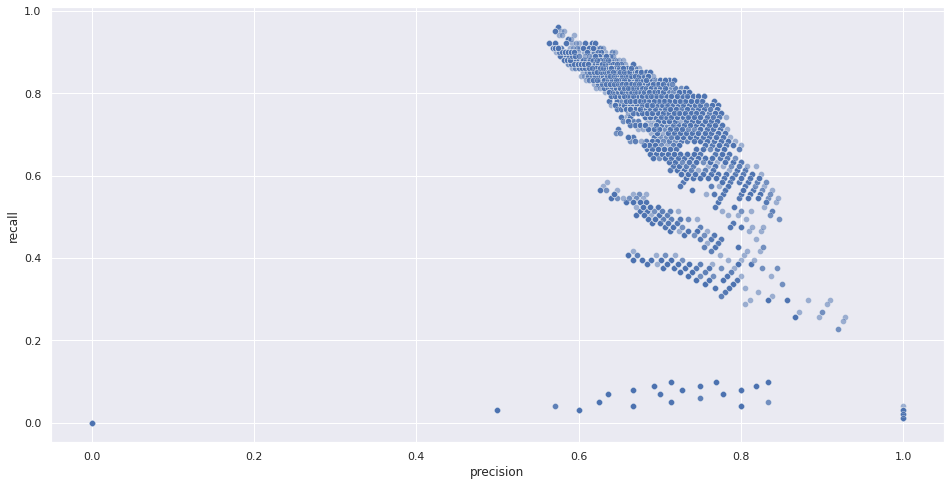

In [ ]:
# with .66 agreement

import seaborn as sns

sns.set(rc={'figure.figsize':(16,8)})
ax = sns.scatterplot(x=prec, y=rec, alpha=0.5)
ax.set(xlabel='precision', ylabel='recall')


#### Pareto

In [ ]:
source_list = [(el[0], el[1], el[2], el[4], k) for k,el in prec_rec_f1_dict_weighted_avg.items()]
prec, rec, f1, surv, key = zip(*source_list)

# Use numpy.linalg.norm:
import numpy as np

a = np.array((0.9, 0.9, 0.9))

myid = None
norms=[]
for b in key:
    norms.append(np.linalg.norm(a-b))
armin = np.argmin(np.array(norms))

print(key[armin])

from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np

points = np.random.randint(0, 10, size=(15, 2))  # Random points in 2-D
points = np.array([[el[0], el[1]] for el in prec_rec_f1_dict_weighted_avg.values()])
f1 = [el[2] for el in prec_rec_f1_dict_weighted_avg.values()]

limit = 0.01

hull = ConvexHull(points)

(0.8868421052631579, 0.8868421052631579, 0.8868421052631579)


In [ ]:
import plotly.graph_objects as go

fig = px.scatter(x=prec, y=rec, color=surv, 
                 labels={
                     "x": "Precision",
                     "y": "Recall",
                     "color": "Reduction rate",
                 }, color_continuous_scale='RdYlBu')

fig.update_traces(marker=dict(size=5,
                              line=dict(width=0.1,
                                        color='slategrey',
                                        )),
                  selector=dict(mode='markers'))

for simplex in hull.simplices:
    if any(points[simplex, 0] < limit) or any(points[simplex, 1] < limit) : continue
    fig.add_trace(
        go.Scatter(x=points[simplex, 0], y=points[simplex, 1], 
        marker = {'color': 'slategrey',
              'size': 0,                 
             })
    )
    
fig.add_trace(
        go.Scattergl(x=[prec[armin]], y=[rec[armin]], 
        marker = {'color': 'mediumseagreen', # firebrick
              'line_color': 'mediumseagreen',
              'size': 8,
              'symbol': 'cross-thin',
              'line_width': 4,  
             })
)
    
# set showlegend property by name of trace
for trace in fig['data']: 
    trace['showlegend'] = False

fig.update_layout(template = 'plotly_white')


fig.data = (fig.data[0],) + (fig.data[1:])

fig.update_layout(
yaxis = dict(
tickfont = dict(size=18)))

fig.update_layout(
yaxis = dict(
tickfont = dict(size=18)))


fig.update_layout(
    # title="Plot Title",
    #xaxis_title="X Axis Title",
    #yaxis_title="Y Axis Title",
    #legend_title="Legend Title",
    font=dict(
        size=18,
    )
)


fig.show()

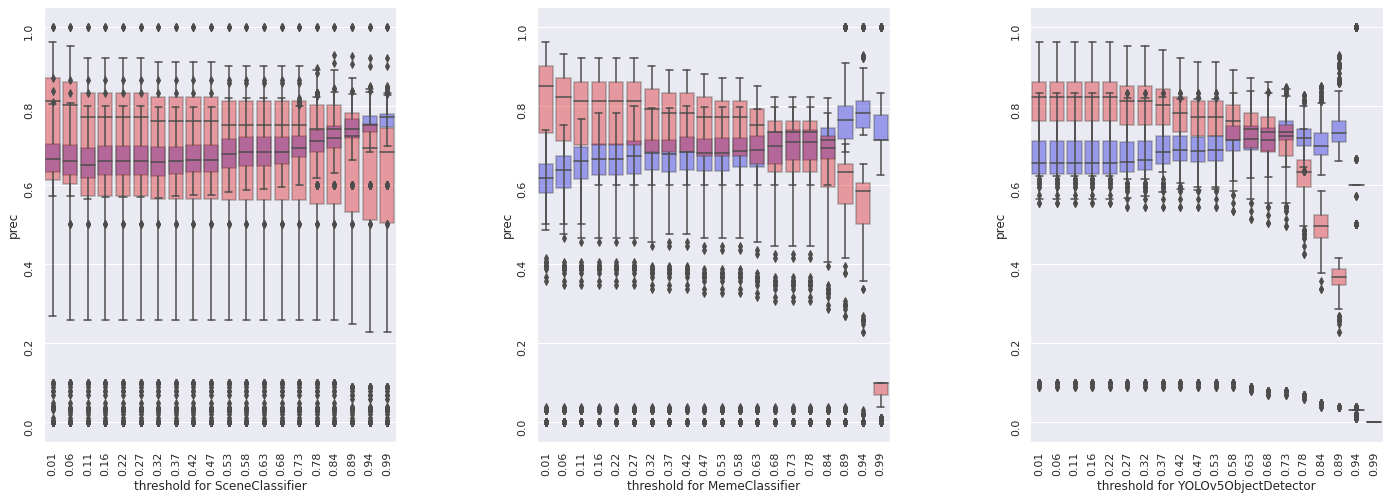

In [ ]:
fig = plt.figure(figsize=(24,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

id = 0

for id in range(len(keys)):

  # thresholds for a single filter as keys
  lab = keys[id]
  myval = [round(el[id], 2) for el in prec_rec_f1_dict_weighted_avg.keys()]

  source_list = [(el[0], el[1], el[2]) for el in prec_rec_f1_dict_weighted_avg.values()]
  prec, rec, f1 = zip(*source_list)

  ax = fig.add_subplot(1, 3, id+1)
  sns.set(rc={'figure.figsize':(12,12)})
  sns.boxplot(x=myval, y=list(prec), boxprops=dict(alpha=.4), color='blue', ax=ax)
  sns.boxplot(x=myval, y=list(rec), boxprops=dict(alpha=.4), color='red', ax=ax)
  ax.set(xlabel='threshold for ' + lab, ylabel='prec')
  ax.tick_params(labelrotation=90) 

In [ ]:
# prec,rec,f1 al variare delle soglie

mins = [np.mean([el[0], el[1], el[2]]) for el in prec_rec_f1_dict_weighted_avg.keys()]
maxs = [np.std([el[0], el[1], el[2]]) for el in prec_rec_f1_dict_weighted_avg.keys()]

source_list = [(el[0], el[1], el[2]) for el in prec_rec_f1_dict_weighted_avg.values()]
prec, rec, f1 = zip(*source_list)

fig = px.scatter_3d(x=mins, y=maxs, z=prec, color=prec, opacity=0.5)

fig.update_layout(scene = dict(
                    xaxis_title='AVG',
                    yaxis_title='STD',
                    zaxis_title='PRECISION'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.update_traces(marker_line_width=0, marker_size=2)

fig.show()

fig = px.scatter_3d(x=mins, y=maxs, z=rec, color=rec, opacity=0.5)

fig.update_layout(scene = dict(
                    xaxis_title='AVG',
                    yaxis_title='STD',
                    zaxis_title='RECALL'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.update_traces(marker_line_width=0, marker_size=2)

fig.show()

fig = px.scatter_3d(x=mins, y=maxs, z=f1, color=f1, opacity=0.5)

fig.update_layout(scene = dict(
                    xaxis_title='AVG',
                    yaxis_title='STD',
                    zaxis_title='F1'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.update_traces(marker_line_width=0, marker_size=2)

fig.show()

In [ ]:
# Majority voting
agreed.truth.value_counts()

False    397
True     101
Name: truth, dtype: int64

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

threshs_ = []
human_costs_ = []
false_negatives_ = []
true_negatives_ = []
passed_ = []

c = 0
for thresholds, thresholded in output_df.items():

  threshs_.append(thresholds)
  true_and_thresholded = agreed.merge(thresholded, on='id')

  # elements passing pipeline
  human_cost = sum(true_and_thresholded.pred == True)/len(true_and_thresholded)
  human_costs_.append(human_cost)

  # lost
  false_negatives = sum((true_and_thresholded.pred == False) & (true_and_thresholded.truth == True))/len(true_and_thresholded)
  false_negatives_.append(false_negatives)

  # correctly filtered
  true_negatives = sum((true_and_thresholded.pred == False) & (true_and_thresholded.truth == False))/len(true_and_thresholded)
  true_negatives_.append(true_negatives)


In [ ]:
human_cost_atom = 1 # estimated
machine_cost_atom = 53/919 # rough estimate in the case study

# global cost
time_costs_ = [(human_cost_atom * i + machine_cost_atom * (1-i)) / human_cost_atom for i in human_costs_]

In [ ]:
meas = pd.DataFrame({'thr' : threshs_, 'human': human_costs_, 'fn': false_negatives_, 'tn': true_negatives_, 'time_cost': time_costs_})

# consistency check
print(np.all(np.isclose(1 - meas.human, meas.fn + meas.tn)))

meas

True


,thr,human,fn,tn,time_cost
0,"(0.01, 0.01, 0.01)",0.33936,0.00803,0.65261,0.37746
1,"(0.01, 0.01, 0.06157894736842105)",0.33936,0.00803,0.65261,0.37746
2,"(0.01, 0.01, 0.1131578947368421)",0.33936,0.00803,0.65261,0.37746
3,"(0.01, 0.01, 0.16473684210526315)",0.33936,0.00803,0.65261,0.37746
4,"(0.01, 0.01, 0.2163157894736842)",0.33936,0.00803,0.65261,0.37746
...,...,...,...,...,...
7995,"(0.99, 0.99, 0.7836842105263158)",0.01606,0.19076,0.79317,0.07281
7996,"(0.99, 0.99, 0.8352631578947368)",0.01004,0.19478,0.79518,0.06713
7997,"(0.99, 0.99, 0.8868421052631579)",0.01004,0.19478,0.79518,0.06713
7998,"(0.99, 0.99, 0.9384210526315789)",0.00201,0.20080,0.79719,0.05956


[Text(0, 0.5, '% elementi persi dalla pipeline (falsi negativi)'),
 Text(0.5, 0, '% elementi filtrati dalla pipeline')]

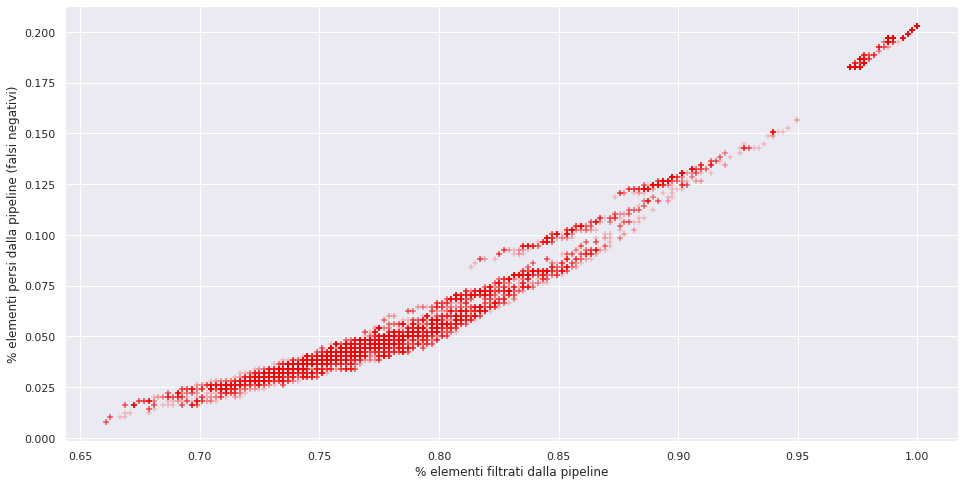

In [ ]:
import seaborn as sns

sns.set(rc={'figure.figsize':(16,8)})
ax = sns.scatterplot(x=[1-h for h in human_costs_], y=false_negatives_, alpha=0.5, color="red", marker="+")
ax.set(xlabel='% elements filtered by pipeline', ylabel='% lost by pipeline (false negatives)')